In [2]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from skimage.io import imread, imshow

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [5]:
# Create two list of the available images and the corresponding labels.
source_path = "S2Hand/"
label_path = "LabelHand/" 

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
        source.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
        label.append(file)

# Sort the lists 
source = sorted(source)
label = sorted(label)
# Sanity Check
print(len(source))
print(len(label))

577
577


In [6]:
# Sanity Check - The source and label images should match
import random
rand_idx = random.randrange(len(source))
print(len(source))
print(len(label))
print(source[rand_idx])
print(label[rand_idx])

577
577
USA_366607_S2Hand_1280128256.tif
USA_366607_LabelHand_1280128256.tif


In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 

X_source = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_label = np.zeros((len(source),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [8]:
for count, file in enumerate(source):
    source_img = imread(source_path +'/' +file )
    new_image = np.transpose(source_img, (1, 2, 0))
    only_rnirswir = new_image[:,:,2:5]
    X_source[count] = only_rnirswir[:,:,:] 


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    Y_label[count] = y 

In [9]:
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder()
Y_resahped = Y_label.reshape(-1,1)
Y_resahped_encoded = labelencoder.fit_transform(Y_resahped)
Y_original = Y_resahped_encoded.reshape(577,128,128,1)
print(np.unique(Y_original))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2]


In [10]:
#Use customary x_train and y_train variables
X_train = X_source
Y_train = Y_original
print(X_train.shape)
print(Y_train.shape)

(577, 128, 128, 3)
(577, 128, 128, 1)


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)# random_state=42

In [12]:
#Load VGG16 model without classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [13]:
# After the first 2 convolutional layers the image dimension changes. 
# So for easy comparison to Y (labels) let us only take first 2 conv layers
# and create a new model to extract features
# New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [14]:
# Now, let us apply feature extractor to our training data
features = new_model.predict(x_train)

13/13 [==============================] - 13s 968ms/step


In [15]:
# Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])
print(X.shape)  #Make it compatible for Random Forest and match Y labels

(6602752, 64)


In [16]:
# Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(6602752,)


In [17]:
# Combine X and Y into a dataframe for easier management
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[0 1 2]
0    3924556
1    1943615
2     734581
Name: Label, dtype: int64


In [18]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

In [19]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20, verbose=10)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.5min remaining:    0.0s


building tree 4 of 20


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s


building tree 5 of 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.3min remaining:    0.0s


building tree 6 of 20


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 20.4min remaining:    0.0s


building tree 7 of 20


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 23.8min remaining:    0.0s


building tree 8 of 20


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.2min remaining:    0.0s


building tree 9 of 20


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 30.8min remaining:    0.0s


building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 67.2min finished


RandomForestClassifier(n_estimators=20, verbose=10)

In [ ]:
#Save model for future use
filename = 'TL_model_s2hand.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
# loaded_model = pickle.load(open(filename, 'rb'))

## TEST The Trained Model

In [20]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(x_test)

6/6 [==============================] - 6s 851ms/step


In [21]:
#Reassign 'features' as X to make it easy to follow
Xtest=features
Xtest = Xtest.reshape(-1, Xtest.shape[3])  #Make it compatible for Random Forest and match Y labels

In [22]:
#Reshape Y to match X
Ytest = y_test.reshape(-1)

In [23]:
#Combine X and Y into a dataframe

dataset_test = pd.DataFrame(Xtest)
dataset_test['Label'] = Ytest
print(dataset_test['Label'].unique())
print(dataset_test['Label'].value_counts())

[1 0 2]
0    1601053
1     941235
2     308528
Name: Label, dtype: int64


In [24]:
#Redefine X and Y for Random Forest
Xtest_for_RF = dataset_test.drop(labels = ['Label'], axis=1)
Ytest_for_RF = dataset_test['Label']

In [25]:
from sklearn import metrics
prediction_test = model.predict(Xtest_for_RF)
##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(Ytest_for_RF, prediction_test))
print("IOU = ", metrics.jaccard_score(Ytest_for_RF, prediction_test, average ="micro"))
print("Precision = ", metrics.precision_score(Ytest_for_RF, prediction_test, average ="micro"))
print("Recall = ", 	metrics.recall_score(Ytest_for_RF, prediction_test, average ="micro"))
print("F1 score = ", metrics.f1_score(Ytest_for_RF, prediction_test, average ="micro"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   35.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


Accuracy =  0.6245632829337284
IOU =  0.45408361954004434
Precision =  0.6245632829337284
Recall =  0.6245632829337284
F1 score =  0.6245632829337284


## Classification Map - Visual Validation

In [ ]:
# The name of the stored model, to be loaded
filename = 'TL_model_s1hand.sav'

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [26]:
def extract_features(imge):
  source_path = "S2Hand/"

  IMG_WIDTH = 128
  IMG_HEIGHT = 128
  IMG_CHANNELS = 3 

  X_source_viz = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

  source_img = imread(source_path +'/' +imge)
  new_image = np.transpose(source_img, (1, 2, 0))
  only_rnirswir = new_image[:,:,2:5]
  X_source_viz[0] = only_rnirswir[:,:,:] 

  features=new_model.predict(X_source_viz)
  X=features
  X = X.reshape(-1, X.shape[3])

  df = pd.DataFrame(X) 

  return df

1/1 [==============================] - 0s 80ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


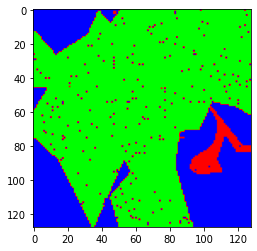

In [31]:
# Plot  a Predicted sample image
source_path = "S2Hand/"
img1 = source[10]
X_viz = extract_features(img1) 
result = model.predict(X_viz)
segmented = result.reshape((128,128))
plt.imshow(segmented, cmap='brg')

[0 1 2]


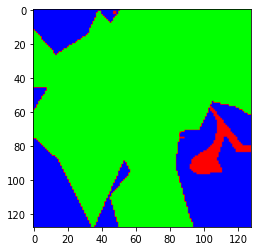

In [41]:
# Plot the corresponding ground truth.
input_mask = Y_train[10].reshape((128,128)) # Use the Encoded Labels
plt.imshow(input_mask, cmap='brg')